In [1]:
import torch
from project.dataset import Dataset, MRIDataset
from torch.utils.data import DataLoader
from project.utils import collate_fn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import nibabel as nib

d:\Programming Files\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.16 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
ds = Dataset()

In [4]:
cases = ds.load_raw_mri()
masks = ds.load_cmb_masks()

In [5]:
labels = [1 if np.any(nib.load(mask).get_fdata()) else 0 for mask in masks]

train_indices, test_indices = train_test_split(
    np.arange(len(masks)),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [6]:
train_cases = [cases[idx] for idx in train_indices]
train_masks = [masks[idx] for idx in train_indices]

test_cases = [cases[idx] for idx in test_indices]
test_masks = [masks[idx] for idx in test_indices]

In [7]:
train_cases

['d:\\Github\\Thesis and ML Project\\Dataset\\VALDO_dataset\\mri_t2s_dir\\sub-227_space-T2S_desc-masked_T2S.nii.gz',
 'd:\\Github\\Thesis and ML Project\\Dataset\\VALDO_dataset\\mri_t2s_dir\\sub-203_space-T2S_desc-masked_T2S.nii.gz',
 'd:\\Github\\Thesis and ML Project\\Dataset\\VALDO_dataset\\mri_t2s_dir\\sub-207_space-T2S_desc-masked_T2S.nii.gz',
 'd:\\Github\\Thesis and ML Project\\Dataset\\VALDO_dataset\\mri_t2s_dir\\sub-218_space-T2S_desc-masked_T2S.nii.gz',
 'd:\\Github\\Thesis and ML Project\\Dataset\\VALDO_dataset\\mri_t2s_dir\\sub-308_space-T2S_desc-masked_T2S.nii.gz',
 'd:\\Github\\Thesis and ML Project\\Dataset\\VALDO_dataset\\mri_t2s_dir\\sub-105_space-T2S_desc-masked_T2S.nii.gz',
 'd:\\Github\\Thesis and ML Project\\Dataset\\VALDO_dataset\\mri_t2s_dir\\sub-318_space-T2S_desc-masked_T2S.nii.gz',
 'd:\\Github\\Thesis and ML Project\\Dataset\\VALDO_dataset\\mri_t2s_dir\\sub-325_space-T2S_desc-masked_T2S.nii.gz',
 'd:\\Github\\Thesis and ML Project\\Dataset\\VALDO_dataset\\mri

In [8]:
test_cases

['d:\\Github\\Thesis and ML Project\\Dataset\\VALDO_dataset\\mri_t2s_dir\\sub-232_space-T2S_desc-masked_T2S.nii.gz',
 'd:\\Github\\Thesis and ML Project\\Dataset\\VALDO_dataset\\mri_t2s_dir\\sub-210_space-T2S_desc-masked_T2S.nii.gz',
 'd:\\Github\\Thesis and ML Project\\Dataset\\VALDO_dataset\\mri_t2s_dir\\sub-230_space-T2S_desc-masked_T2S.nii.gz',
 'd:\\Github\\Thesis and ML Project\\Dataset\\VALDO_dataset\\mri_t2s_dir\\sub-304_space-T2S_desc-masked_T2S.nii.gz',
 'd:\\Github\\Thesis and ML Project\\Dataset\\VALDO_dataset\\mri_t2s_dir\\sub-213_space-T2S_desc-masked_T2S.nii.gz',
 'd:\\Github\\Thesis and ML Project\\Dataset\\VALDO_dataset\\mri_t2s_dir\\sub-310_space-T2S_desc-masked_T2S.nii.gz',
 'd:\\Github\\Thesis and ML Project\\Dataset\\VALDO_dataset\\mri_t2s_dir\\sub-305_space-T2S_desc-masked_T2S.nii.gz',
 'd:\\Github\\Thesis and ML Project\\Dataset\\VALDO_dataset\\mri_t2s_dir\\sub-302_space-T2S_desc-masked_T2S.nii.gz',
 'd:\\Github\\Thesis and ML Project\\Dataset\\VALDO_dataset\\mri

In [9]:
train_dataset = MRIDataset(cases=train_cases, masks=train_masks, target_size=(50, 50), rpn_mode=True)
test_dataset = MRIDataset(cases=test_cases, masks=test_masks, target_size=(50, 50), rpn_mode=True)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [11]:
def plot_all_slices(img_tensor):
    num_slices = img_tensor.shape[0]  
    height, width = img_tensor.shape[2], img_tensor.shape[3] 
    
    num_cols = 5
    num_rows = (num_slices + num_cols - 1) // num_cols  
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    
    for i in range(num_slices):
        ax = axes[i // num_cols, i % num_cols]
        
        mri_slice = img_tensor[i].squeeze().cpu().numpy() 
        
        ax.imshow(mri_slice, cmap='gray')
        ax.set_title(f'Slice {i+1}')
        ax.axis('off')
    
    for j in range(num_slices, num_rows * num_cols):
        axes[j // num_cols, j % num_cols].axis('off')

    plt.tight_layout()
    plt.show()

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


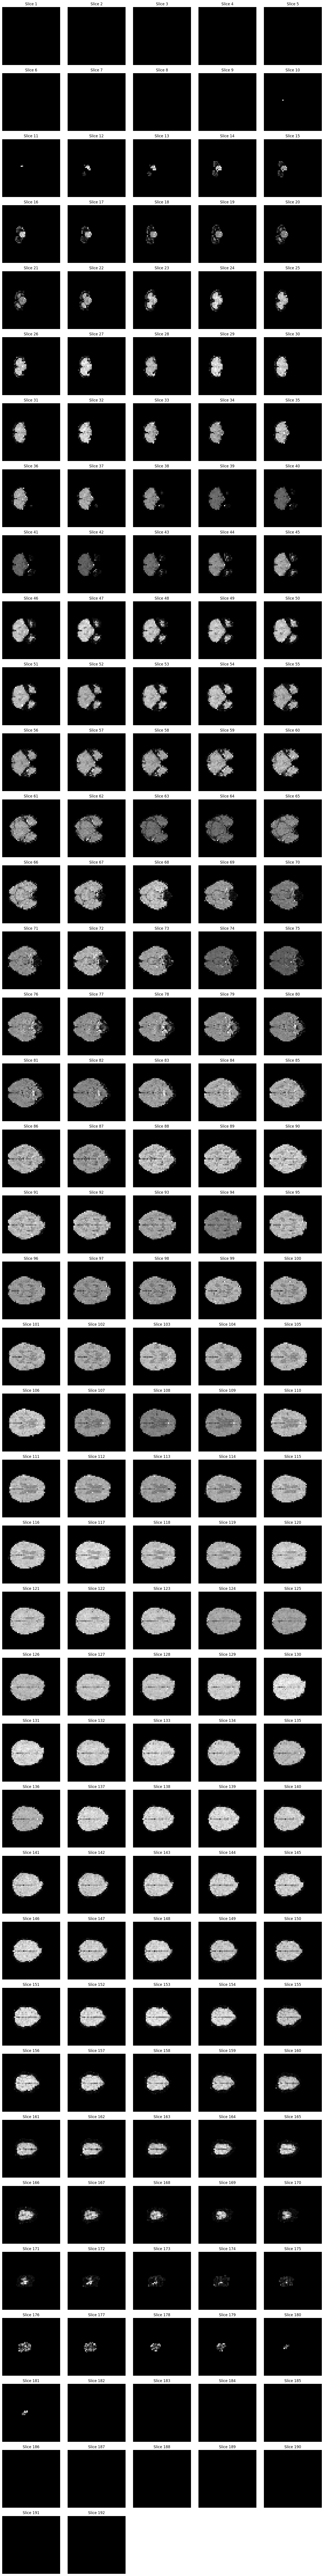

In [12]:
mri_tensor, mask_tensor, _, _ = train_dataset[0]  # Get the first case
plot_all_slices(mri_tensor)

In [13]:
mri_tensor.shape

torch.Size([192, 1, 1, 50, 50])

In [14]:
class Fitter:
    def __init__(self, config):
        self.model = config['model']
        self.optimizer = config['optimizer'](self.model.parameters(), lr=config['lr'])
        self.device = config['device']
        self.epochs = config['epochs']
        self.loss = config['loss']

    def fit(self, train_loader, val_loader):
        train_history = []
        val_history = []

        # loop with self.epochs
        for epoch in range(self.epochs):
            train_loss = self.train_one_epoch(train_loader)

            train_history.append(train_loss)

        return train_history

    def train_one_epoch(self, train_loader):
        self.model.train()
        # train model
        pass

    def validation(self, val_loader):
        self.model.eval()
        with torch.inference_mode():
            # conduct evaluation
            pass
        pass

In [15]:
class RPNFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        
        loss_history = []
        for slices, masks, case, counts in train_loader:
            num_slices = slices.shape[0]
            print(f"num of slices {num_slices}")
            
            print(f"slice shape {slices.shape}")
            
            masks = masks.view(num_slices, 1, -1).float().to(self.device)
            
            x = slices.view(num_slices, 1, -1).float().to(self.device)
            print(f"x shape {x.shape}")
            
            y = []
            
            
            for slc in range(num_slices):
                y = self.model(x, slc)
                losses = self.loss(y, masks[slc])
                loss_history.append(losses)
                self.optimizer.zero_grad()
                losses.backward()
                self.optimizer.step()
        
        return loss_history
        # requery rpn with 
        
    def validation(self, val_loader):
        self.model.eval()
        with torch.inference_mode():
            loss_history = []
            # feed all samples
            for slices, masks, case, counts in val_loader:
                num_slices = slices.shape[0]
                masks = masks.float().to(self.device)
                x = slices.view(num_slices, 1, 1, -1).float().to(self.device)
                y = []
                for slc in x:
                    out = self.model(slc)
                    y.append(out)
                y = torch.stack(y)
                # calculate loss
                losses = self.loss(y, masks)
                loss_history.append(losses)
            
            return loss_history




In [16]:
import torch
import torch.nn as nn
import math

class RPNPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class RPN(nn.Module):
    def __init__(self, input_dim, output_dim, nh, dim_ff):
        super().__init__()

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nh, dim_feedforward=dim_ff)
        self.trans_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        self.posenc = RPNPositionalEncoding(d_model=input_dim)
        self.fc = nn.Linear(input_dim, output_dim)
        self.lrel = nn.ELU()

    def forward(self, x, i):
        slices = x
        x = self.posenc(x)
        x = self.trans_encoder(x)
        x = self.trans_encoder(slices[i])
        x = self.fc(x)
        x = self.lrel(x)

        return x

In [17]:
config = {
    'model': RPN(50**2, 4, 5, 2500).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 1,
    'loss': nn.SmoothL1Loss(),
    # 'loss': nn.MSELoss(),
    'lr': 0.0000001
}

d:\Programming Files\Python\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [18]:
fitter = RPNFitter(config)

In [19]:
hist = fitter.fit(train_loader, train_loader)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])


d:\Programming Files\Python\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


num of slices 39
slice shape torch.Size([39, 1, 1, 50, 50])
x shape torch.Size([39, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 35
slice shape torch.Size([35, 1, 1, 50, 50])
x shape torch.Size([35, 1, 2500])
num of slices 36
slice shape torch.Size([36, 1, 1, 50, 50])
x shape torch.Size([36, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])
num of slices 39
slice shape torch.Size([39, 1, 1, 50, 50])
x shape torch.Size([39, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])
num of slices 39
slice shape torch.Size([39, 1, 1, 50, 50])
x shape torch.Size([39, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 35
slice shape torch.Size([35, 1, 1, 50, 50])
x shape torch.Size([35, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 35
slice shape torch.Size([35, 1, 1, 50, 50])
x shape torch.Size([35, 1, 2500])
num of slices 39
slice shape torch.Size([39, 1, 1, 50, 50])
x shape torch.Size([39, 1, 2500])
num of slices 39
slice shape torch.Size([39, 1, 1, 50, 50])
x shape torch.Size([39, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])
num of slices 39
slice shape torch.Size([39, 1, 1, 50, 50])
x shape torch.Size([39, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 35
slice shape torch.Size([35, 1, 1, 50, 50])
x shape torch.Size([35, 1, 2500])
num of slices 39
slice shape torch.Size([39, 1, 1, 50, 50])
x shape torch.Size([39, 1, 2500])
num of slices 39
slice shape torch.Size([39, 1, 1, 50, 50])
x shape torch.Size([39, 1, 2500])
num of slices 39
slice shape torch.Size([39, 1, 1, 50, 50])
x shape torch.Size([39, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 37
slice shape torch.Size([37, 1, 1, 50, 50])
x shape torch.Size([37, 1, 2500])
num of slices 39
slice shape torch.Size([39, 1, 1, 50, 50])
x shape torch.Size([39, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])
num of slices 39
slice shape torch.Size([39, 1, 1, 50, 50])
x shape torch.Size([39, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 35
slice shape torch.Size([35, 1, 1, 50, 50])
x shape torch.Size([35, 1, 2500])
num of slices 39
slice shape torch.Size([39, 1, 1, 50, 50])
x shape torch.Size([39, 1, 2500])
num of slices 49
slice shape torch.Size([49, 1, 1, 50, 50])
x shape torch.Size([49, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 35
slice shape torch.Size([35, 1, 1, 50, 50])
x shape torch.Size([35, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])
num of slices 39
slice shape torch.Size([39, 1, 1, 50, 50])
x shape torch.Size([39, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 35
slice shape torch.Size([35, 1, 1, 50, 50])
x shape torch.Size([35, 1, 2500])
num of slices 39
slice shape torch.Size([39, 1, 1, 50, 50])
x shape torch.Size([39, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 35
slice shape torch.Size([35, 1, 1, 50, 50])
x shape torch.Size([35, 1, 2500])
num of slices 39
slice shape torch.Size([39, 1, 1, 50, 50])
x shape torch.Size([39, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])
num of slices 39
slice shape torch.Size([39, 1, 1, 50, 50])
x shape torch.Size([39, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])
num of slices 39
slice shape torch.Size([39, 1, 1, 50, 50])
x shape torch.Size([39, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])
num of slices 36
slice shape torch.Size([36, 1, 1, 50, 50])
x shape torch.Size([36, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 192
slice shape torch.Size([192, 1, 1, 50, 50])
x shape torch.Size([192, 1, 2500])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


num of slices 35
slice shape torch.Size([35, 1, 1, 50, 50])
x shape torch.Size([35, 1, 2500])
num of slices 48
slice shape torch.Size([48, 1, 1, 50, 50])
x shape torch.Size([48, 1, 2500])


In [20]:
torch.stack(hist[0])

tensor([0.4918, 0.4635, 0.4209,  ..., 0.0087, 0.0015, 0.0015], device='cuda:0',
       grad_fn=<StackBackward0>)

In [21]:
torch.tensor(hist[0])

tensor([0.4918, 0.4635, 0.4209,  ..., 0.0087, 0.0015, 0.0015])

In [22]:
model = fitter.model

<Axes: >

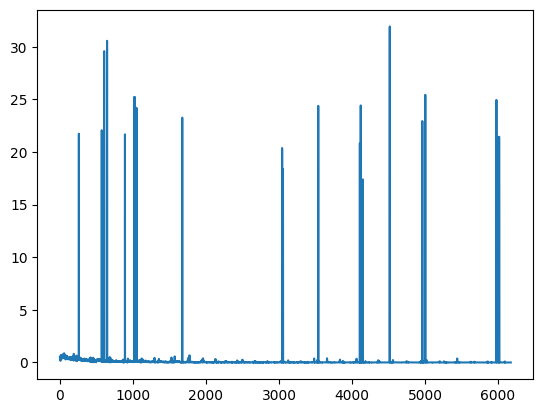

In [23]:
import seaborn as sns

sns.lineplot(torch.tensor(hist[0]))

In [24]:
slices, masks, case, counts = next(enumerate(train_loader))[1]

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [25]:
num_slices = slices.shape[0]

In [26]:
x = slices.view(num_slices, 1, -1).float().to(device)

In [27]:
for i in range(0, 35):
    y = model(x, i)
    print(f"mask {i}: {masks[i]}")
    print(f"y: {y}")

mask 0: tensor([[[-1., -1., -1., -1.]]])
y: tensor([[-0.8875, -0.7457, -0.7052, -0.7563]], device='cuda:0',
       grad_fn=<EluBackward0>)
mask 1: tensor([[[-1., -1., -1., -1.]]])
y: tensor([[-0.9083, -0.8894, -0.8495, -0.8850]], device='cuda:0',
       grad_fn=<EluBackward0>)
mask 2: tensor([[[-1., -1., -1., -1.]]])
y: tensor([[-0.8350, -0.9054, -0.8733, -0.9040]], device='cuda:0',
       grad_fn=<EluBackward0>)
mask 3: tensor([[[-1., -1., -1., -1.]]])
y: tensor([[-0.9059, -0.9204, -0.8256, -0.9356]], device='cuda:0',
       grad_fn=<EluBackward0>)
mask 4: tensor([[[-1., -1., -1., -1.]]])
y: tensor([[-0.9087, -0.9348, -0.8858, -0.9322]], device='cuda:0',
       grad_fn=<EluBackward0>)
mask 5: tensor([[[13., 27., 14., 28.]]])
y: tensor([[-0.8828, -0.8858, -0.8880, -0.8898]], device='cuda:0',
       grad_fn=<EluBackward0>)
mask 6: tensor([[[-1., -1., -1., -1.]]])
y: tensor([[-0.9243, -0.9315, -0.9039, -0.9307]], device='cuda:0',
       grad_fn=<EluBackward0>)
mask 7: tensor([[[-1., -1.,